# Libraries

In [2]:
import os
import glob
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import ProjectiveTransform, warp

from skimage.transform import resize

from skimage.color import rgb2gray

import skimage
from skimage.filters import threshold_multiotsu

# Import Sentinel Images

In [9]:
base_path = 'images'
images_data = {}
images_files = {}

periods = ['Before', 'After']
types = ['8bit', '16bit', 'bands']
channel_patterns = ['B02', 'B03', 'B04', 'B08', 'B11', 'B12']

for period in periods:
    for img_type in types:
        folder_path = os.path.join(base_path, period, img_type)
        tiff_files = glob.glob(os.path.join(folder_path, '*.tiff'))

        if img_type in ['8bit', '16bit']:
            for file_path in tiff_files:
                file_name = os.path.basename(file_path)
                if 'True_color' in file_name:
                    variable_name = f'true_color_{period.lower()}_{img_type}'
                elif 'False_color' in file_name:
                    variable_name = f'false_color_{period.lower()}_{img_type}'
                elif 'Highlight' in file_name:
                    variable_name = f'highlight_{period.lower()}_{img_type}'
                else:
                    continue

                img = imread(file_path)
                img = img.astype('uint8' if img_type == '8bit' else 'uint16')
                images_data[variable_name] = img
                images_files[variable_name] = file_path

        else:
            for channel in channel_patterns:
                matching_files = sorted([f for f in tiff_files if channel in os.path.basename(f)])
                preferred_files = [f for f in matching_files if '_Raw.tiff' in f]
                selected_file = preferred_files[-1] if preferred_files else (matching_files[-1] if matching_files else None)

                if selected_file:
                    variable_name = f'{channel.lower()}_{period.lower()}_band'
                    img = imread(selected_file).astype('float32')
                    images_data[variable_name] = img
                    images_files[variable_name] = selected_file

globals().update(images_data)

print(f"\n Loaded {len(images_data)} images:\n")
for key in images_data:
    arr = images_data[key]
    path = images_files[key]
    print(
        f"{key:35} shape={str(arr.shape):>16} dtype={str(arr.dtype):>9} "
        f"min={np.min(arr):8.1f} max={np.max(arr):8.1f}  file={os.path.basename(path)}"
    )



 Loaded 24 images:

false_color_before_8bit             shape=    (99, 146, 3) dtype=    uint8 min=     0.0 max=   241.0  file=2023-05-05-00_00_2023-05-05-23_59_Sentinel-2_L1C_False_color.tiff
highlight_before_8bit               shape=    (99, 146, 3) dtype=    uint8 min=     0.0 max=   169.0  file=2023-05-05-00_00_2023-05-05-23_59_Sentinel-2_L1C_Highlight_Optimized_Natural_Color.tiff
true_color_before_8bit              shape=    (99, 146, 3) dtype=    uint8 min=     0.0 max=   214.0  file=2023-05-05-00_00_2023-05-05-23_59_Sentinel-2_L1C_True_color.tiff
false_color_before_16bit            shape=    (99, 146, 3) dtype=   uint16 min=     0.0 max= 61597.0  file=2023-05-05-00_00_2023-05-05-23_59_Sentinel-2_L1C_False_color.tiff
highlight_before_16bit              shape=    (99, 146, 3) dtype=   uint16 min=     0.0 max= 43140.0  file=2023-05-05-00_00_2023-05-05-23_59_Sentinel-2_L1C_Highlight_Optimized_Natural_Color.tiff
true_color_before_16bit             shape=    (99, 146, 3) dtype=   uin

## Description

### Code Functionality Overview

1. **Initialization of paths and image container**

python
base_path = 'images'
images_data = {}

A dictionary `images_data` is created to store all loaded images. It serves as the central container for image data during the project.

---

2. **Defining image categories**

```python
periods = ['Before', 'After']
types = ['8bit', '16bit', 'bands']
channel_patterns = ['B02', 'B03', 'B04', 'B08', 'B11', 'B12']
```

- `periods`: distinguishes images taken **before** and **after** a key event (e.g., a disaster).
- `types`: defines the type of data: RGB compositions or raw spectral bands.
- `channel_patterns`: specifies the spectral bands to be extracted (e.g., for NDVI: B08 - B04).

---

3. **Main loop: traversing folders and loading images**

- For each `period` and `type`, all `.tiff` files in the corresponding subfolder are collected.

- **For RGB compositions (`8 bit`, `16 bit`)**:
  - File names are checked for keywords like `True_color`, `False_color`, or `Highlight`.
  - Each image is loaded and converted to the correct data type (`uint8` or `uint16`), then stored in the `images_data` dictionary under a descriptive name.

- **For raw spectral bands (`bands`)**:
  - For each specified band (e.g., `B08`), the most suitable `.tiff` file is selected: preferring raw versions (`_Raw.tiff`) if available.
  - The selected image is loaded as `float32` and added to the dictionary.

---

4. **Injecting loaded images into the global namespace**

```python
globals().update(images_data)
```

This makes each image accessible directly by its variable name, e.g., `true_color_before_8bit`, `b08_after_band`, etc., without having to use dictionary keys.

---

5. **Verification and summary output**

Finally, the code prints the number of loaded images and their shapes and data types:

```python
print(f"Loaded {len(images_data)} images:")
for key in images_data:
    print(key, images_data[key].shape, images_data[key].dtype)
```

---

### Summary

This part of the code:
- Automates the ingestion of well-structured satellite imagery,
- Handles both RGB compositions and raw spectral bands,
- Converts data to appropriate types (`uint8`, `uint16`, `float32`),
- Registers all loaded images as global variables for easier access,
- Prepares the dataset for further image processing steps.


# Preliminary visualisation

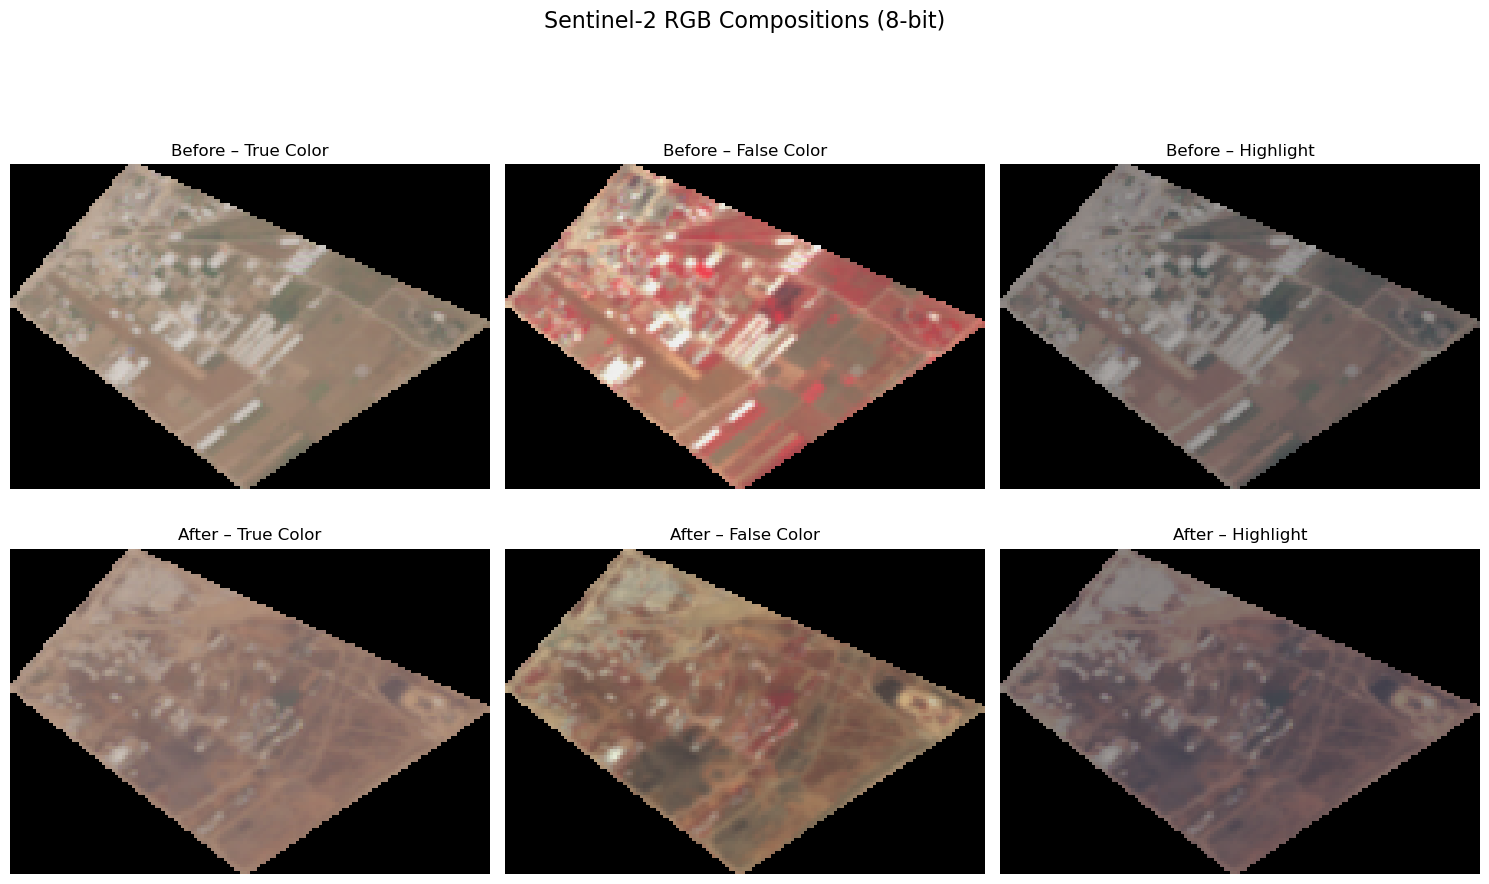

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Sentinel-2 RGB Compositions (8-bit)', fontsize=16)

composition_names = ['true_color', 'false_color', 'highlight']

for col, comp in enumerate(composition_names):
    for row, period in enumerate(['before', 'after']):
        var_name = f'{comp}_{period}_8bit'
        img = globals()[var_name]

        if img.ndim == 3 and img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))  # (3, H, W) → (H, W, 3)

        ax = axes[row, col]
        ax.imshow(img)
        ax.set_title(f'{period.title()} – {comp.replace("_", " ").title()}')
        ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Description

### Visualization of Sentinel-2 RGB Compositions (8-bit)

This section displays the RGB compositions of Sentinel-2 images that were previously loaded and stored in variables such as `true_color_before_8bit`, `false_color_after_8bit`, etc.

---

###  Code overview:

1. **Creates a 2x3 grid** of subplots using `matplotlib`:
   - **Rows** represent time periods: `before` and `after` the observed event.
   - **Columns** represent different RGB image types:
     - `True Color` – natural colors using bands B04 (red), B03 (green), B02 (blue).
     - `False Color` – often uses B08 (NIR), B04 (red), B03 (green) for vegetation analysis.
     - `Highlight` – a custom composition that may enhance specific features (e.g., damage).

2. **Iterates over each subplot** and:
   - Constructs the variable name dynamically using `f'{comp}_{period}_8bit'`.
   - Accesses the corresponding image from the global namespace.
   - Transposes the image if necessary to match (Height, Width, Channels).
   - Displays the image using `imshow()`.

3. **Adds clean titles and formatting**:
   - Titles reflect the time period and image type.
   - Axes are turned off for a cleaner visual output.
   - Layout is adjusted using `tight_layout()` and a custom `suptitle()` is added at the top.

---

###  Output

The final output is a neatly arranged grid showing six RGB images, allowing visual comparison between pre-event and post-event conditions across different image compositions. This helps assess surface and structural changes such as vegetation health, infrastructure damage, or flood extents.



# Geometrical transformations

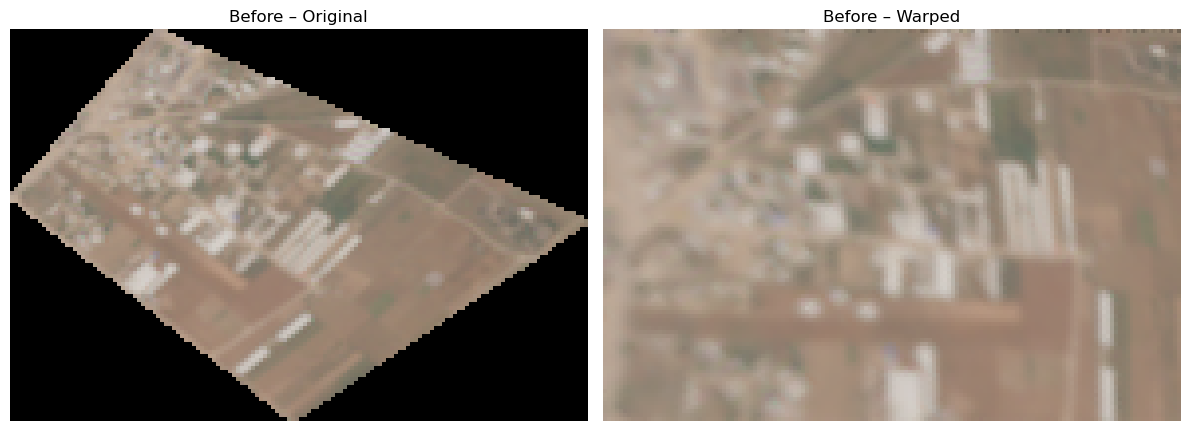

In [5]:
src = np.array([
    [0, 0],
    [0, 100],
    [150, 100],
    [150, 0]
])

dst = np.array([
    [37, 0],
    [0, 42],
    [71, 98],
    [145, 48]
])

transform = ProjectiveTransform()
transform.estimate(src, dst)

def apply_projective(image):
    if image.ndim == 3:
        if image.shape[0] == 3:
            image = np.transpose(image, (1, 2, 0))
        warped_channels = []
        for i in range(3):
            warped = warp(image[:, :, i], transform, output_shape=image.shape[:2], preserve_range=True)
            warped_channels.append(warped)
        warped_rgb = np.stack(warped_channels, axis=-1)
        return warped_rgb.astype(image.dtype)
    else:
        warped = warp(image, transform, output_shape=image.shape[:2], preserve_range=True)
        return warped.astype(image.dtype)

warped_images = {}
for var_name, img in images_data.items():
    warped = apply_projective(img)
    warped_images[var_name + '_warped'] = warped

globals().update(warped_images)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
img_orig = true_color_before_8bit
if img_orig.shape[0] == 3:
    img_orig = np.transpose(img_orig, (1, 2, 0))

img_warped = true_color_before_8bit_warped

ax1.imshow(img_orig)
ax1.set_title('Before – Original')
ax1.axis('off')

ax2.imshow(img_warped.astype(np.uint8))
ax2.set_title('Before – Warped')
ax2.axis('off')

plt.tight_layout()
plt.show()

## Description

###  Geometric Alignment – Projective Transformation

In this section, we apply a **projective (homography) transformation** to all loaded images in order to geometrically align them to a new perspective. This transformation is particularly useful when aligning satellite images that come from different viewing angles or when correcting distortions from sensor or motion effects.

---

###  What the code does:

1. **Defines control points**:
   ```python
   src = np.array([
       [0, 0],
       [0, 100],
       [150, 100],
       [150, 0]
   ])

   dst = np.array([
       [37, 0],
       [0, 42],
       [71, 98],
       [145, 48]
   ])
   ```
   - `src`: coordinates in the original image.
   - `dst`: desired coordinates after transformation.
   - These pairs define how to map the original image to the new geometry.

---

2. **Estimates the projective transformation**:
   ```python
   transform = ProjectiveTransform()
   transform.estimate(src, dst)
   ```
   - This computes a homography matrix that will be used to warp the image so that `src → dst`.

---

3. **Applies the transformation to all images**:
   ```python
   def apply_projective(image):
       ...
   ```
   - For **RGB images (3D)**:
     - Each channel is transformed independently using `skimage.transform.warp`.
     - The result is reconstructed into a warped RGB image.
   - For **grayscale/single-band images (2D)**:
     - The image is warped directly.
   - All transformed images are stored in the `warped_images` dictionary with `_warped` added to their variable name.

---

4. **Updates the global namespace**:
   ```python
   globals().update(warped_images)
   ```
   - This makes all warped images available as independent variables, e.g.:
     - `true_color_before_8bit_warped`
     - `b08_after_band_warped`
     - etc.

---

5. **Displays a visual comparison** between the original and warped RGB image:

```python
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
...
plt.show()
```

- **Left panel**: original RGB composition (`true_color_before_8bit`)
- **Right panel**: warped version (`true_color_before_8bit_warped`)
- This confirms the spatial transformation and helps visually validate the effect.

---

###  Summary

This transformation stage:
- Applies a consistent geometric alignment to all images.
- Ensures that different bands or time-step images can be overlaid or compared pixel-by-pixel.
- Provides a visual check to verify correctness of the warp.
- Prepares the dataset for further operations such as NDVI computation, segmentation, or change detection.



# Normalization and Super Resolution

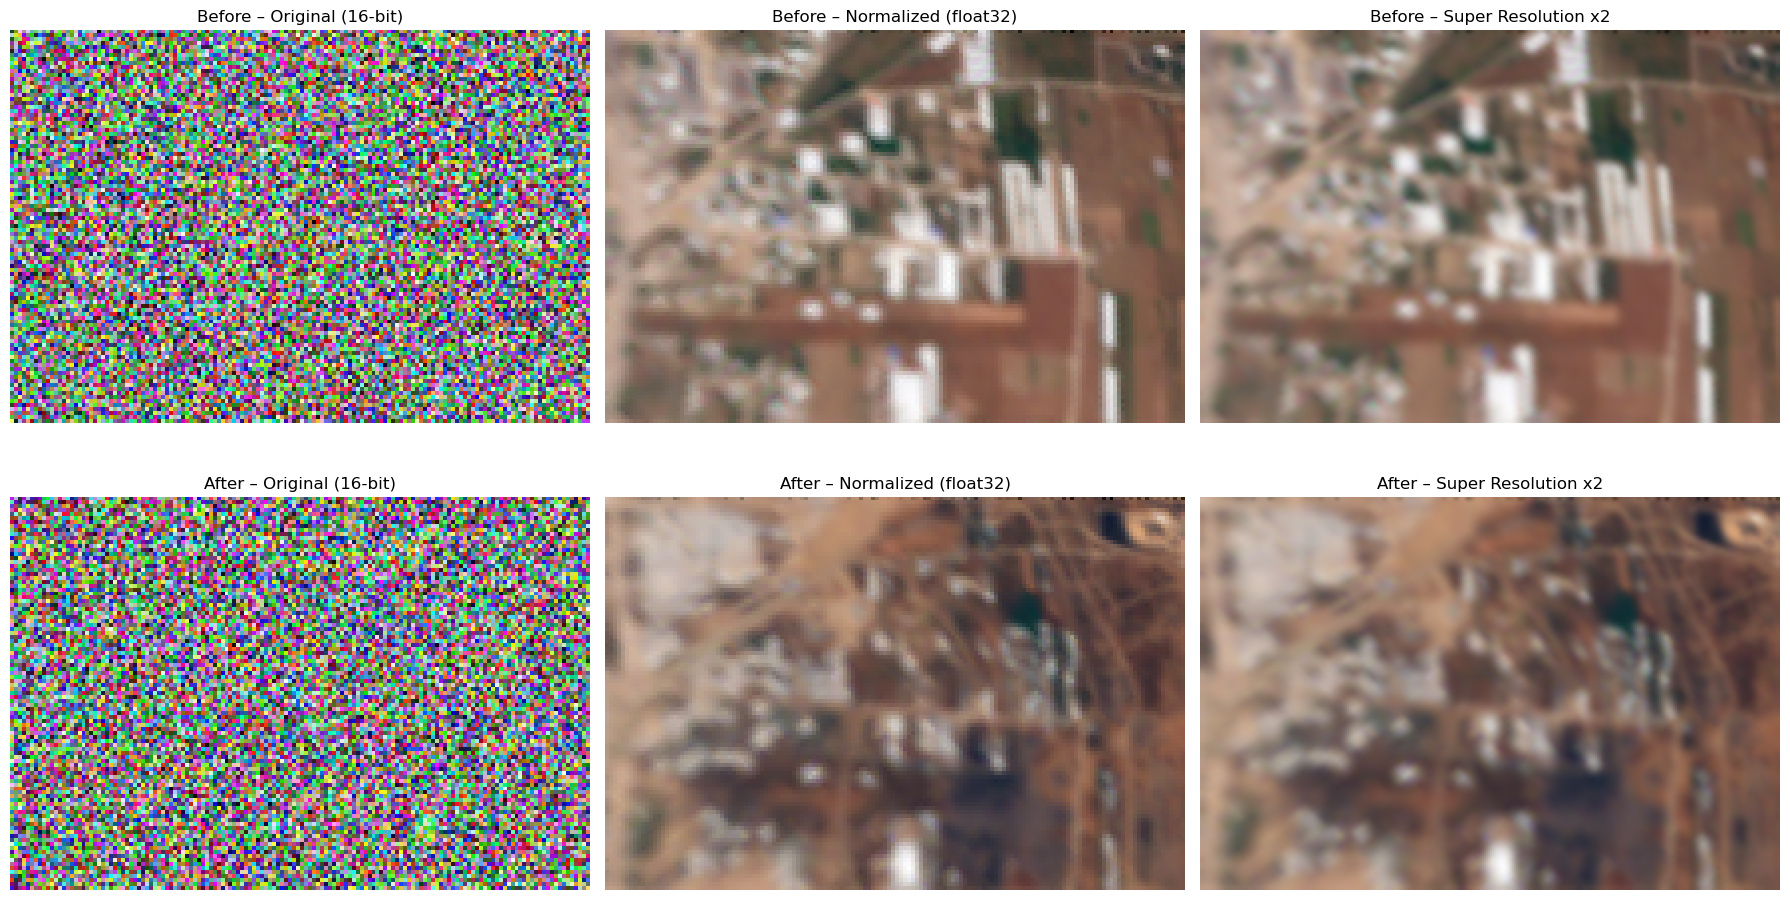

In [6]:
def normalize_image(image):
    """
    Normalizacja wartości obrazu:
    - uint16 → [0, 1]
    - float32 → [0, 1]
    """
    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min() + 1e-10)

def apply_super_resolution(image, scale_factor=2):
    output_shape = (int(image.shape[0] * scale_factor), int(image.shape[1] * scale_factor))
    if image.ndim == 3:
        return resize(image, (output_shape[0], output_shape[1], image.shape[2]), anti_aliasing=True, preserve_range=True)
    else:
        return resize(image, output_shape, anti_aliasing=True, preserve_range=True)

# Normalization
normalized_images = {}

for name, image in warped_images.items():
    if name.endswith('_warped') and ('_16bit' in name or '_band' in name):
        if image.ndim == 3:
            norm_channels = [normalize_image(image[:, :, i]) for i in range(3)]
            normalized = np.stack(norm_channels, axis=-1)
        else:
            normalized = normalize_image(image)
        normalized_images[name + '_norm'] = normalized

globals().update(normalized_images)

# Comparison before anf after
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
titles = ['Original (16-bit)', 'Normalized (float32)', 'Super Resolution x2']
sides = ['before', 'after']

for row, phase in enumerate(sides):
    img_orig = warped_images[f'true_color_{phase}_16bit_warped']
    img_norm = normalized_images[f'true_color_{phase}_16bit_warped_norm']
    img_sr = apply_super_resolution(img_norm)

    if img_orig.shape[0] == 3:
        img_orig = np.transpose(img_orig, (1, 2, 0))

    axs[row, 0].imshow(img_orig.astype(np.uint8))
    axs[row, 1].imshow(img_norm)
    axs[row, 2].imshow(img_sr)

    for col in range(3):
        axs[row, col].axis('off')
        axs[row, col].set_title(f"{sides[row].capitalize()} – {titles[col]}")

plt.tight_layout()
plt.show()


## Description

### Image Normalization and Super Resolution

In this section, we preprocess geometrically aligned (warped) satellite images by:
- **Normalizing** their pixel values to a `[0, 1]` range.
- **Upscaling** them using a simple super-resolution technique (resizing with anti-aliasing).
- **Visualizing** the transformation pipeline to compare the warped original, normalized, and upscaled versions.

---

### What the code does:

1. **Image normalization function**

```python
def normalize_image(image):
    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min() + 1e-10)
```

- Converts images (either `uint16` or `float32`) to a normalized `float32` range between 0 and 1.
- A small constant (`1e-10`) prevents division by zero.

---

2. **Super-resolution upscaling function**

```python
def apply_super_resolution(image, scale_factor=2):
    ...
```

- Upscales the image by a given `scale_factor` (default: 2×) using `skimage.transform.resize`.
- Anti-aliasing is applied to reduce artifacts during resizing.
- Works for both grayscale (2D) and RGB (3D) images.

---

3. **Apply normalization to selected warped images**

```python
for name, image in warped_images.items():
    if name.endswith('_warped') and ('_16bit' in name or '_band' in name):
        ...
```

- Filters out only warped images of type `16bit` or `band`.
- For each image:
  - If it's RGB (3D), normalizes each channel separately and stacks them.
  - If it's single-channel (2D), normalizes directly.
- Saves normalized results into `normalized_images` with `_norm` suffix.

---

4. **Visualization: original vs. normalized vs. super-resolved**

```python
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
```

- **Left**: original warped RGB image (`true_color_before_16bit_warped`)
- **Middle**: normalized version
- **Right**: upscaled (2×) super-resolved image

This visual check confirms the effect of both intensity scaling and upsampling on the data, which is particularly useful for improving model performance or visual interpretability.

---

### Summary

This stage performs essential image preprocessing:
- **Normalization** helps standardize image intensities for further analysis or machine learning input.
- **Super-resolution (resizing)** improves spatial resolution using simple interpolation.
- Visualization ensures that each step behaves as expected before proceeding to change detection or analysis.


# NDVI Mask

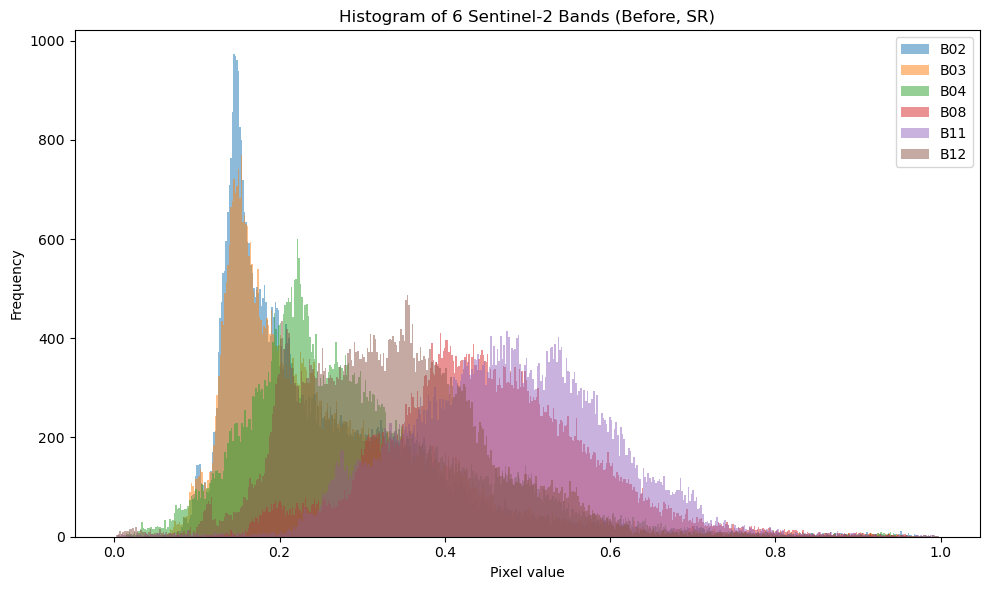

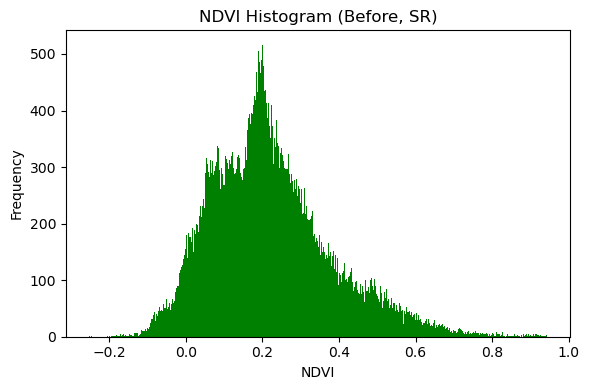

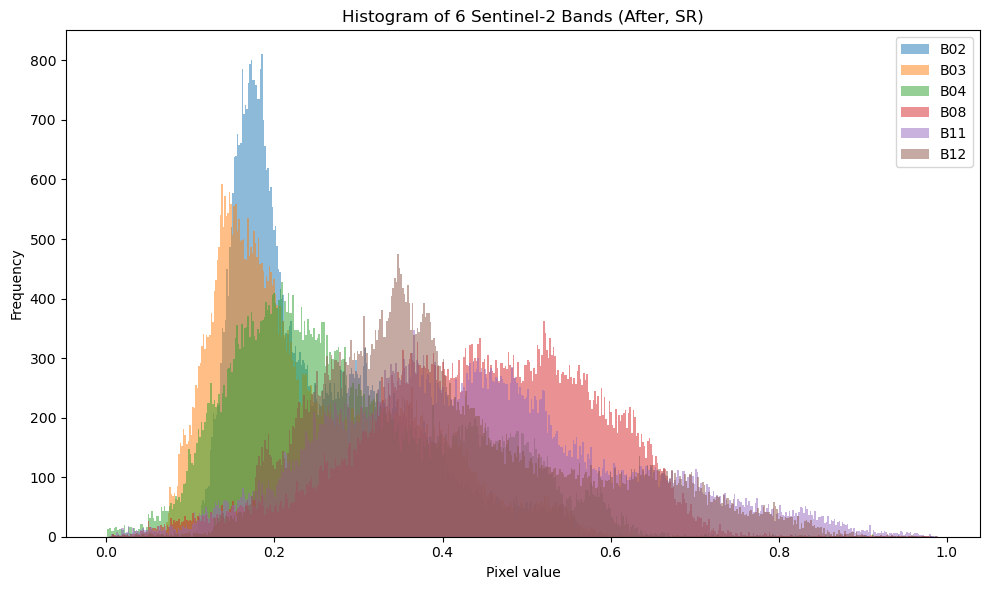

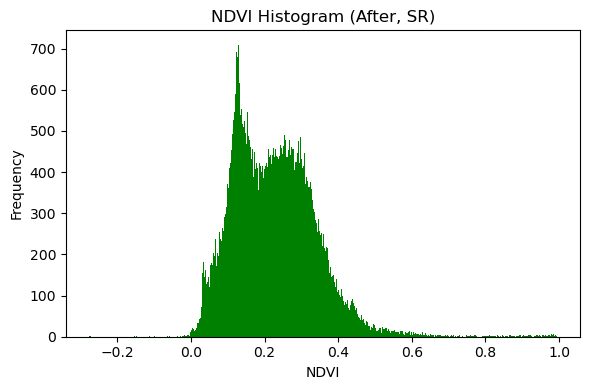

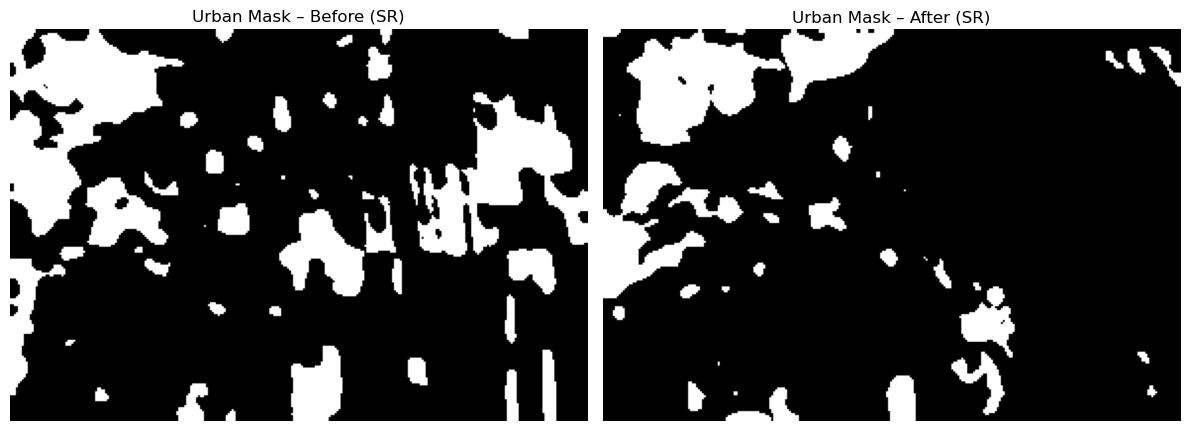

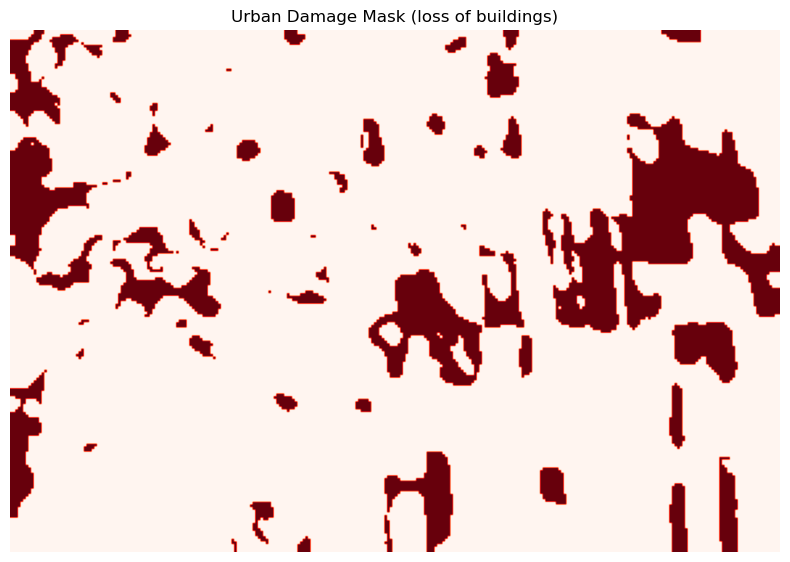

In [7]:
def plot_histogram(stack, names, title, bins=512, alpha=0.5):
    plt.figure(figsize=(10, 6))
    for i, name in enumerate(names):
        plt.hist(stack[..., i].ravel(), bins=bins, alpha=alpha, label=name)
    plt.title(title)
    plt.xlabel('Pixel value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()



def compute_ndvi(b08, b04):
    denom = b08 + b04 + 1e-10
    ndvi = (b08 - b04) / denom
    return np.clip(ndvi, -1, 1)

def compute_baresoil(b11, b04, b08, b02):
    num = (b11 + b04) - (b08 + b02)
    denom = (b11 + b04) + (b08 + b02) + 1e-10
    return 2.5 * num / denom

def urban_mask(b02, b03, b04, b08, b11):
    ndvi = compute_ndvi(b08, b04)
    urban = (ndvi < 0.1) | (b11 > 0.8)
    return urban.astype(np.uint8)

band_names = ['B02', 'B03', 'B04', 'B08', 'B11', 'B12']

# Super Resolution for every bands before and after
b02_before_sr = apply_super_resolution(b02_before_band_warped_norm)
b03_before_sr = apply_super_resolution(b03_before_band_warped_norm)
b04_before_sr = apply_super_resolution(b04_before_band_warped_norm)
b08_before_sr = apply_super_resolution(b08_before_band_warped_norm)
b11_before_sr = apply_super_resolution(b11_before_band_warped_norm)
b12_before_sr = apply_super_resolution(b12_before_band_warped_norm)

b02_after_sr = apply_super_resolution(b02_after_band_warped_norm)
b03_after_sr = apply_super_resolution(b03_after_band_warped_norm)
b04_after_sr = apply_super_resolution(b04_after_band_warped_norm)
b08_after_sr = apply_super_resolution(b08_after_band_warped_norm)
b11_after_sr = apply_super_resolution(b11_after_band_warped_norm)
b12_after_sr = apply_super_resolution(b12_after_band_warped_norm)

# before
stack_before_sr = np.stack([
    b02_before_sr, b03_before_sr, b04_before_sr,
    b08_before_sr, b11_before_sr, b12_before_sr
], axis=-1)

plot_histogram(stack_before_sr, band_names, 'Histogram of 6 Sentinel-2 Bands (Before, SR)')

ndvi_before_sr = compute_ndvi(b08_before_sr, b04_before_sr)
plt.figure(figsize=(6, 4))
plt.hist(ndvi_before_sr.ravel(), bins=512, color='green')
plt.title('NDVI Histogram (Before, SR)')
plt.xlabel('NDVI')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

urban_before_sr = urban_mask(
    b02_before_sr, b03_before_sr, b04_before_sr,
    b08_before_sr, b11_before_sr
)

# after
stack_after_sr = np.stack([
    b02_after_sr, b03_after_sr, b04_after_sr,
    b08_after_sr, b11_after_sr, b12_after_sr
], axis=-1)

plot_histogram(stack_after_sr, band_names, 'Histogram of 6 Sentinel-2 Bands (After, SR)')

ndvi_after_sr = compute_ndvi(b08_after_sr, b04_after_sr)
plt.figure(figsize=(6, 4))
plt.hist(ndvi_after_sr.ravel(), bins=512, color='green')
plt.title('NDVI Histogram (After, SR)')
plt.xlabel('NDVI')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

urban_after_sr = urban_mask(
    b02_after_sr, b03_after_sr, b04_after_sr,
    b08_after_sr, b11_after_sr
)

# visualisation of urban masks
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(urban_before_sr, cmap='gray')
ax1.set_title('Urban Mask – Before (SR)')
ax1.axis('off')

ax2.imshow(urban_after_sr, cmap='gray')
ax2.set_title('Urban Mask – After (SR)')
ax2.axis('off')
plt.tight_layout()
plt.show()

# 1. Loss of buildings (the white ones have disappeared)
lost_buildings = (urban_before_sr == 1) & (urban_after_sr == 0)

# 2. Increase in development (optional, for assessment of new buildings)
new_buildings = (urban_before_sr == 0) & (urban_after_sr == 1)

# 3. Final damage mask (usually only loss of buildings)
damage_mask = lost_buildings.astype(np.uint8)

# 4. Visualisation of the damage mask
plt.figure(figsize=(8, 6))
plt.imshow(damage_mask, cmap='Reds')
plt.title('Urban Damage Mask (loss of buildings)')
plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
pixel_area_m2 = 25  # 5m x 5m after Super Resolution
damage_pixels = np.sum(damage_mask)
damage_area_m2 = damage_pixels * pixel_area_m2
damage_area_km2 = damage_area_m2 / 1e6

total_pixels = damage_mask.size
total_area_km2 = total_pixels * pixel_area_m2 / 1e6
damage_percent = 100 * damage_pixels / total_pixels

print(f"Area of damage: {damage_area_km2:.4f} km²")
print(f"Share of damage: {damage_percent:.2f}% of the area under consideration")

Area of damage: 0.2308 km²
Share of damage: 15.96% of the area under consideration


## Description

### Urban Area Detection, NDVI Analysis, and Damage Assessment Pipeline

This section processes Sentinel-2 satellite data for **urban change detection and damage quantification**. The workflow includes:
- Histogram analysis of spectral bands,
- NDVI computation and visualization,
- Urban area extraction (urban mask),
- Change detection (building loss) between "Before" and "After" periods,
- Visualization and quantification of damaged area.

---

### Explanation

1. **Histogram Visualization for Multispectral Data**

   - The `plot_histogram` function visualizes the distribution of pixel intensities for each of the six main Sentinel-2 bands (`B02`, `B03`, `B04`, `B08`, `B11`, `B12`) both before and after the event.
   - These histograms help assess normalization, dynamic range, and potential anomalies.

2. **NDVI Calculation and Histogram**

   - NDVI (Normalized Difference Vegetation Index) is computed using the NIR (`B08`) and red (`B04`) bands:
     ```
     NDVI = (B08 - B04) / (B08 + B04)
     ```
   - NDVI is visualized via a histogram.

3. **Urban Mask Creation**

   - Urban areas are extracted by combining NDVI and the SWIR band (`B11`):
     - **Urban pixels** are defined as regions where NDVI < 0.1 or where `B11` > 0.8 (high SWIR reflectance typical for built-up surfaces).
   - Masks are created for both "Before" and "After" images, producing binary maps of urban presence.

4. **Visual Comparison of Urban Masks**

   - The binary masks for each time period are displayed side-by-side for qualitative comparison.

5. **Damage Mask Calculation (Change Detection)**

   - **Lost buildings**: pixels classified as urban in the "Before" mask but not in the "After" mask.
   - **New buildings**: (optional) pixels that appear as urban only in the "After" mask.
   - The primary **damage mask** highlights only lost urban areas, interpreted as destroyed or removed buildings.

6. **Visualization of Damage Mask**

   - The final damage mask is visualized in red, clearly showing regions of significant building loss.

7. **Quantitative Area Estimation**

   - The number of damage pixels is multiplied by the area per pixel (assumed 25 m² for 5m x 5m resolution after super-resolution).
   - Damage area is reported in km², along with the percentage of the total analyzed area affected.

---

### Summary

This analysis enables:
- Quantitative and qualitative assessment of urban change due to disasters or redevelopment.
- Detection and mapping of damaged or lost buildings at the city scale.
- Insight into the spatial extent and severity of damage using objective, reproducible criteria.

Such tools are crucial for **post-disaster assessment**, urban planning, and remote sensing-based monitoring.


# Thresholding

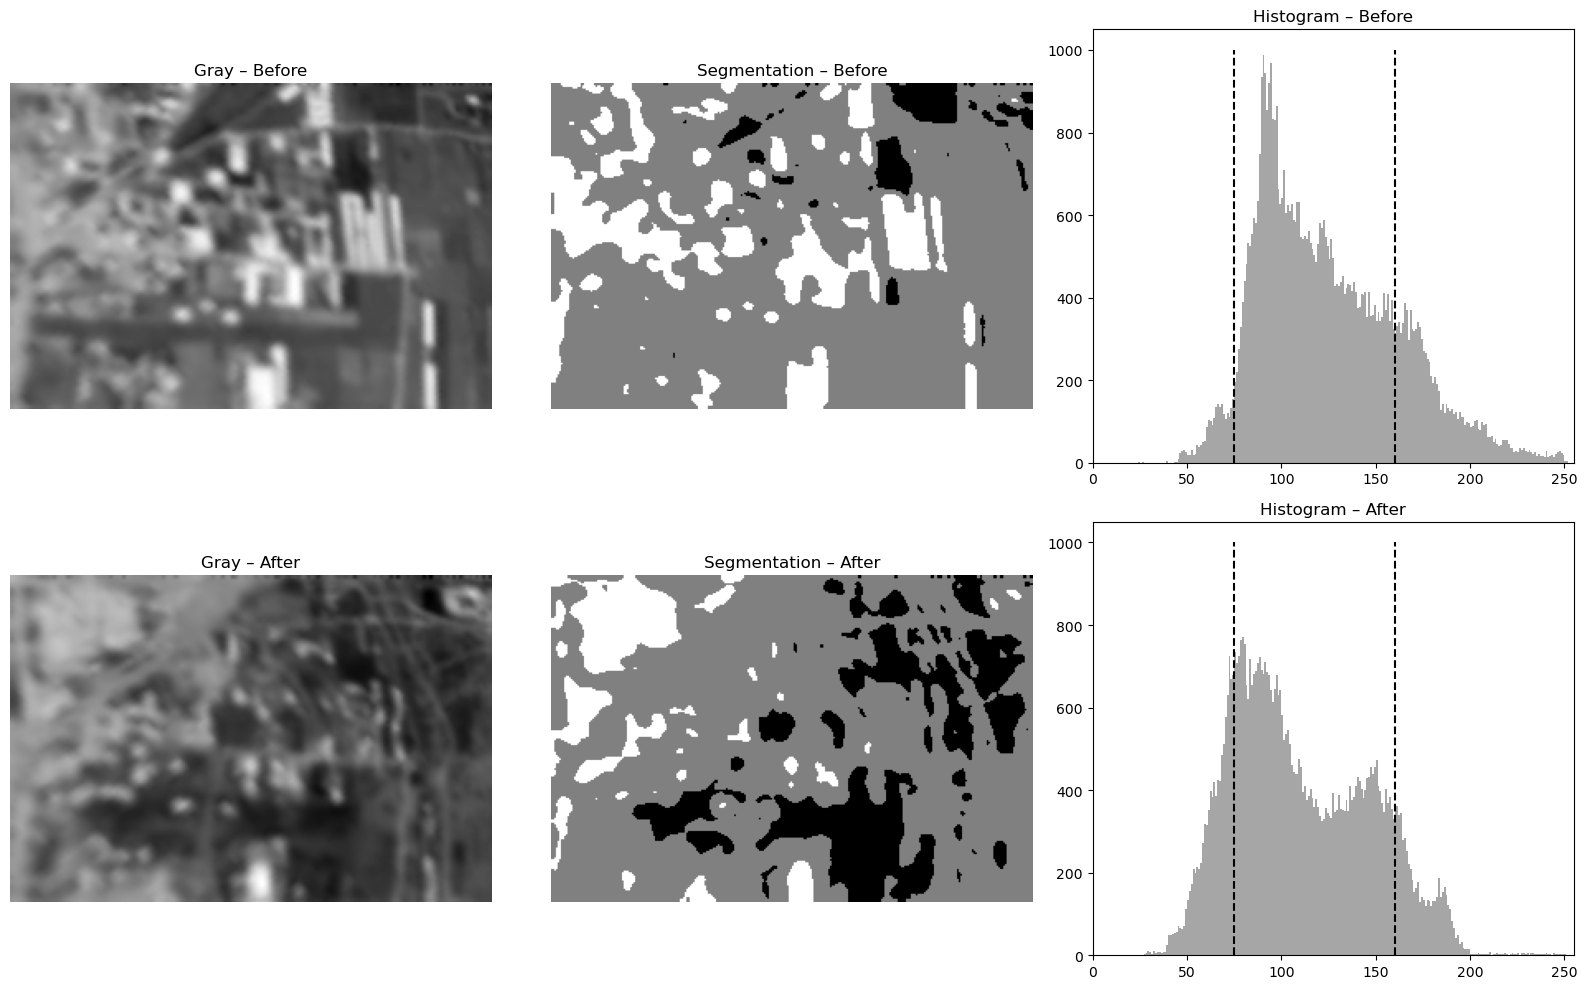

In [9]:
# RGB images (after ProjectiveTransform and normalisation)
img_before = true_color_before_16bit_warped_norm
img_after = true_color_after_16bit_warped_norm

img_before = apply_super_resolution(img_before)
img_after = apply_super_resolution(img_after)

# Making sure they are in (H, W, 3) format
if img_before.shape[0] == 3:
    img_before = np.transpose(img_before, (1, 2, 0))
if img_after.shape[0] == 3:
    img_after = np.transpose(img_after, (1, 2, 0))

# Conversion to greyscale and uint8
gray_before = (rgb2gray(img_before) * 255).astype(np.uint8)
gray_after = (rgb2gray(img_after) * 255).astype(np.uint8)

# Thresholds for segmentation
thresholds = [75, 160]

# segmentation before
seg_before = np.zeros_like(gray_before)
seg_before[(gray_before > thresholds[0]) & (gray_before <= thresholds[1])] = 1
seg_before[gray_before > thresholds[1]] = 2

# segmentation after
seg_after = np.zeros_like(gray_after)
seg_after[(gray_after > thresholds[0]) & (gray_after <= thresholds[1])] = 1
seg_after[gray_after > thresholds[1]] = 2

# visualisation
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

# Brightness (gray)
axs[0, 0].imshow(gray_before, cmap='gray')
axs[0, 0].set_title("Gray – Before")
axs[0, 0].axis('off')

axs[1, 0].imshow(gray_after, cmap='gray')
axs[1, 0].set_title("Gray – After")
axs[1, 0].axis('off')

# segmentation
axs[0, 1].imshow(seg_before, cmap='gray')
axs[0, 1].set_title("Segmentation – Before")
axs[0, 1].axis('off')

axs[1, 1].imshow(seg_after, cmap='gray')
axs[1, 1].set_title("Segmentation – After")
axs[1, 1].axis('off')

# Histograms
axs[0, 2].hist(gray_before.ravel(), bins=np.arange(256), color='gray', alpha=0.7)
axs[0, 2].vlines(thresholds, ymin=0, ymax=1000, color='black', linestyle='--')
axs[0, 2].set_title("Histogram – Before")
axs[0, 2].set_xlim(0, 255)

axs[1, 2].hist(gray_after.ravel(), bins=np.arange(256), color='gray', alpha=0.7)
axs[1, 2].vlines(thresholds, ymin=0, ymax=1000, color='black', linestyle='--')
axs[1, 2].set_title("Histogram – After")
axs[1, 2].set_xlim(0, 255)

plt.tight_layout()
plt.show()


In [10]:
# Mask of lost bright pixels
lost_white = (seg_before == 2) & (seg_after != 2)

# Mask of newly formed black pixels
new_dark = (seg_before != 0) & (seg_after == 0)

# Damage final mask
damage_mask = lost_white | new_dark

# Statistics
pixel_area_m2 = 25  # 5m x 5m
damage_pixels = np.sum(damage_mask)
damage_area_m2 = damage_pixels * pixel_area_m2
damage_area_km2 = damage_area_m2 / 1e6

# Results
print(f"Destroyed pixels: {damage_pixels}")
print(f"Area of damage: {damage_area_m2:.0f} m² = {damage_area_km2:.4f} km²")


Zniszczonych pikseli: 17477
Powierzchnia zniszczeń: 436925 m² = 0.4369 km²


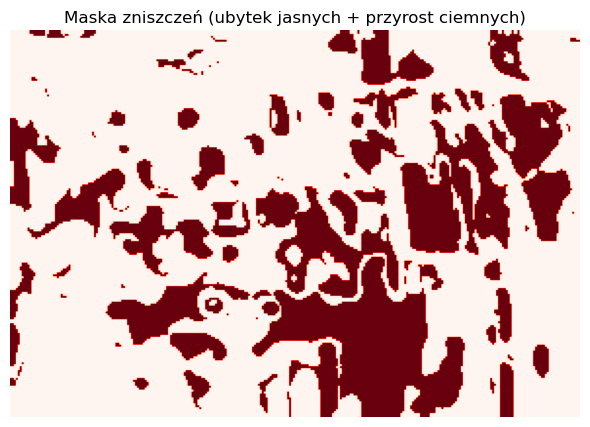

In [11]:
plt.figure(figsize=(6, 6))
plt.imshow(damage_mask, cmap='Reds')
plt.title("Damage mask (loss of light + increase in dark)")
plt.axis('off')
plt.tight_layout()
plt.show()


In [12]:
# Area per pixel after super resolution (5m × 5m)
pixel_area_m2 = 25

# Total number of pixels
total_pixels = damage_mask.size
total_area_m2 = total_pixels * pixel_area_m2
total_area_km2 = total_area_m2 / 1e6

# Destroyed pixels
damage_pixels = np.sum(damage_mask)
damage_area_m2 = damage_pixels * pixel_area_m2
damage_area_km2 = damage_area_m2 / 1e6

# 4. Percentage of damage
damage_percent = 100 * damage_pixels / total_pixels

# 5. Wyniki
print(f"The total area:       {total_area_km2:.4f} km²")
print(f"Area of damage: {damage_area_km2:.4f} km²")
print(f"Share of damage:       {damage_percent:.2f}%")

The total area:       1.4454 km²
Area of damage: 0.4369 km²
Share of damage:       30.23%


## Description 

### RGB-Based Damage Detection: Grayscale Segmentation and Threshold Analysis

This section demonstrates a simple, **threshold-based segmentation approach** for detecting and quantifying image changes (e.g., building loss or land cover change) between two time points using RGB Sentinel-2 images.

---

### Explanation

1. **Input Preparation:**
   - Uses normalized and projectively transformed RGB images, upscaled via super-resolution for improved resolution and pixel-wise comparison.
   - Ensures the data shape is (H, W, 3) for standard image processing.

2. **Conversion to Grayscale:**
   - Both "before" and "after" RGB images are converted to single-channel grayscale (uint8, range 0–255) using `rgb2gray`.
   - Grayscale simplifies segmentation by reducing dimensionality.

3. **Thresholding for Segmentation:**
   - Two thresholds (`75` and `160`) define three regions:
     - **0**: dark pixels (background/shadows)
     - **1**: mid-tone pixels
     - **2**: bright pixels (e.g., rooftops, concrete, or other high-reflectance surfaces)
   - Produces segmented masks for both "before" and "after" images.

4. **Visualization:**
   - Shows grayscale images, segmentations, and pixel value histograms before and after the event.
   - Histograms with threshold lines help visualize the separation between classes and choose appropriate thresholds.

5. **Change Detection Masks:**
   - **Lost white (bright) pixels:** Areas that were bright before but are no longer bright after (possible loss of buildings or reflective surfaces).
   - **New dark pixels:** Areas that became newly dark after the event.
   - **Combined damage mask:** Logical OR of the above; highlights all relevant damaged or changed regions.

6. **Damage Quantification:**
   - Counts the number of pixels in the damage mask.
   - Calculates the damaged area (in m² and km²) using pixel size (here, 25 m² per pixel for 5×5 m super-resolution).
   - Computes the damage percentage relative to the total area.

7. **Visualization of Damage:**
   - The final damage mask is visualized in red, highlighting areas of significant change.

---

### Summary

This approach:
- Provides a fast and interpretable method for detecting major changes in surface reflectance (e.g., collapsed buildings, burned areas, or flood coverage) using simple grayscale thresholds.
- Allows for quick estimation of damaged area as both absolute surface (km²) and relative percentage.
- Offers clear visualization at each step, supporting both expert analysis and automated reporting.


# Multi-otsu thresholding for only buildings damage analysis

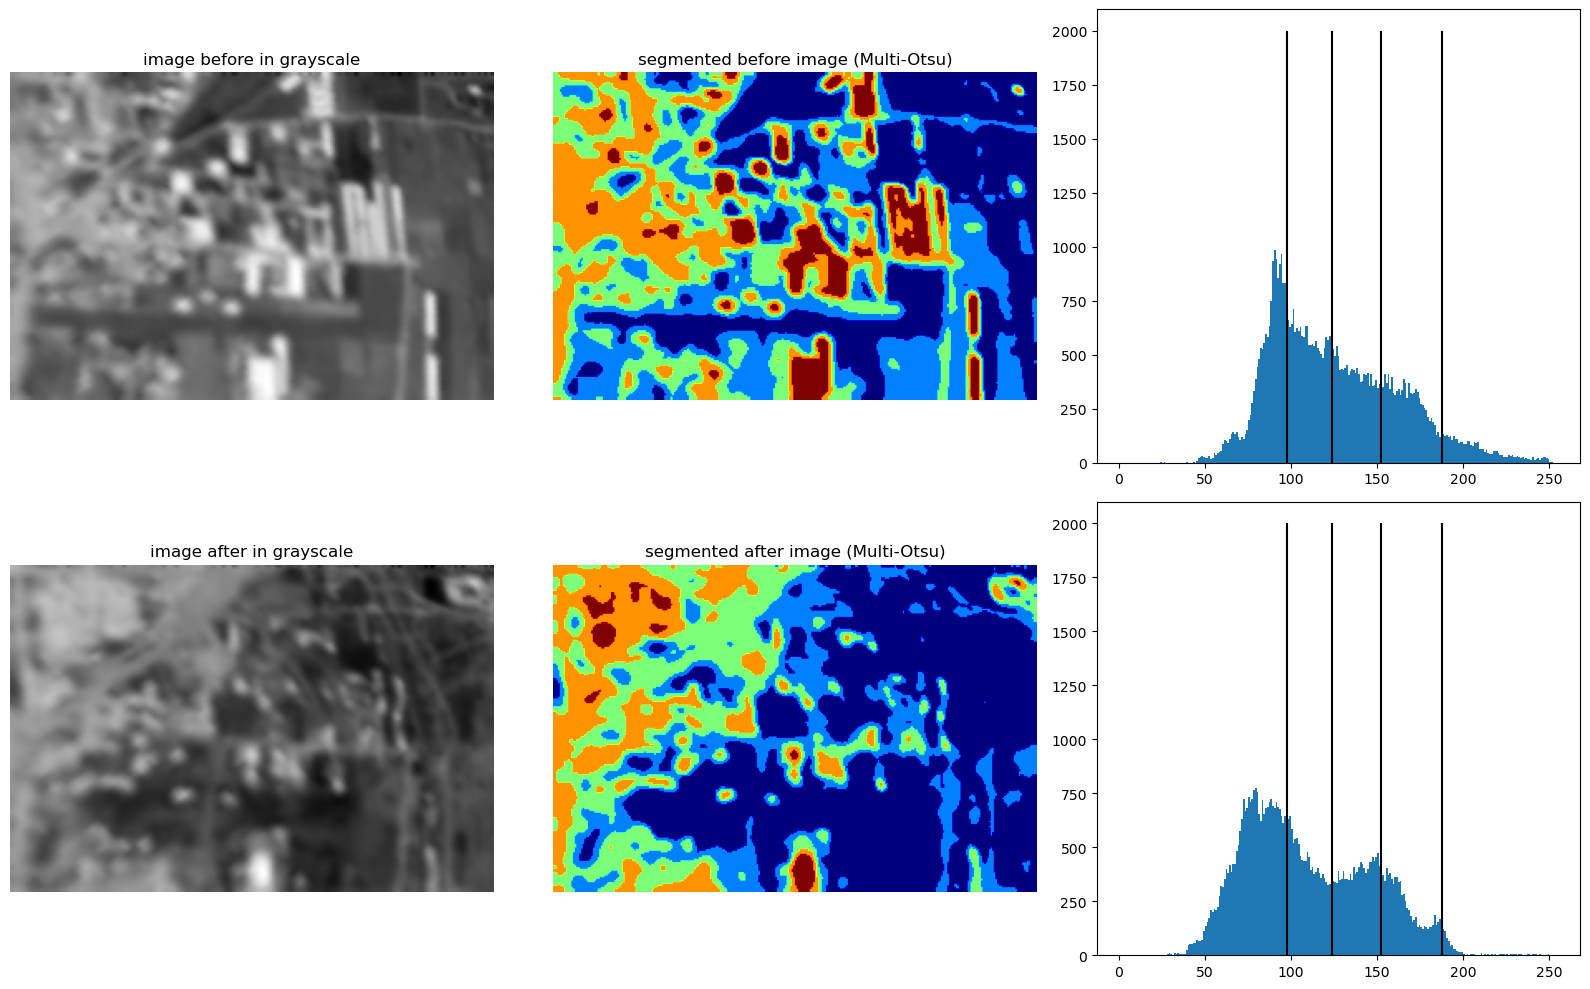

In [13]:
img_before = apply_super_resolution(true_color_before_16bit_warped_norm)
img_after = apply_super_resolution(true_color_after_16bit_warped_norm)

img_before_gray = skimage.color.rgb2gray(img_before)*255
img_after_gray = skimage.color.rgb2gray(img_after)*255

thresholds = threshold_multiotsu(img_before_gray, classes=5)
regions_before = np.digitize(img_before_gray, bins=thresholds)
regions_after = np.digitize(img_after_gray, bins=thresholds)


fig, axs = plt.subplots(2, 3, figsize=(16, 10))
axs[0, 0].imshow(img_before_gray, cmap='gray')
axs[0, 0].set_title("image before in grayscale")
axs[0, 0].axis('off')

axs[1, 0].imshow(img_after_gray, cmap='gray')
axs[1, 0].set_title("image after in grayscale")
axs[1, 0].axis('off')

axs[0, 1].imshow(regions_before, cmap='jet')
axs[0, 1].set_title("segmented before image (Multi-Otsu)")
axs[0, 1].axis('off')

axs[1, 1].imshow(regions_after, cmap='jet')
axs[1, 1].set_title("segmented after image (Multi-Otsu)")
axs[1, 1].axis('off')

axs[0, 2].hist(img_before_gray.flatten(), bins=np.arange(256));
axs[0, 2].vlines(thresholds, ymin=0, ymax = 2000, color="black")

axs[1, 2].hist(img_after_gray.flatten(), bins=np.arange(256));
axs[1, 2].vlines(thresholds, ymin=0, ymax = 2000, color="black")

plt.tight_layout()
plt.show()

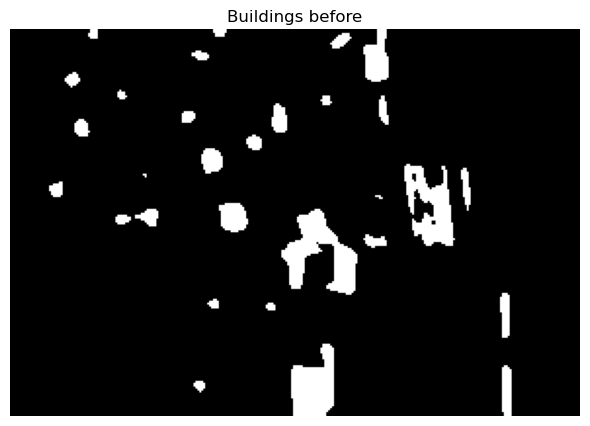

In [14]:
segment_mask = (regions_before == 4)

plt.figure(figsize=(6, 6))
plt.imshow(segment_mask, cmap='gray')
plt.title(f"Buildings before")
plt.axis('off')
plt.tight_layout()
plt.show()

buildings_pixels_before = np.sum(segment_mask)

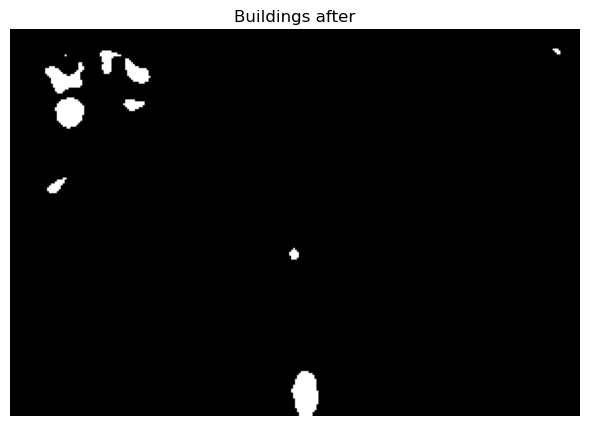

In [15]:
segment_mask = (regions_after == 4)

plt.figure(figsize=(6, 6))
plt.imshow(segment_mask, cmap='gray')
plt.title(f"Buildings after")
plt.axis('off')
plt.tight_layout()
plt.show()

buildings_pixels_after = np.sum(segment_mask)

In [16]:
damage_pixels = buildings_pixels_before - buildings_pixels_after
damage_percent = 100 * (damage_pixels / buildings_pixels_before)
print(f"Share of building damage:       {damage_percent:.2f}%")

Share of building damage:       76.10%


## Description

### Advanced Segmentation for Building Damage: Multi-Otsu Method

This section demonstrates the use of **Multi-Otsu thresholding** for unsupervised segmentation and quantification of building damage between two time periods in high-resolution Sentinel-2 RGB images.

---

### Step-by-Step Explanation

1. **Preparation and Super-Resolution**
   - `true_color_before_16bit_warped_norm` and `true_color_after_16bit_warped_norm` images are upscaled for finer analysis.
   - Images are converted to grayscale (`0–255`) for segmentation.

2. **Multi-Otsu Segmentation**
   - Multi-Otsu is an advanced thresholding algorithm that automatically determines multiple intensity thresholds to partition an image into a specified number of classes (`classes=5` here).
   - The resulting thresholds split the grayscale image into distinct regions (e.g., shadows, vegetation, rooftops, roads, highly reflective surfaces).
   - Each pixel is assigned a segment label using `np.digitize`, resulting in segmented masks for both before and after images.

3. **Visualization**
   - Displays, for each period:
     - The grayscale image,
     - The segmented image (color-coded by class),
     - The grayscale histogram with vertical lines showing the thresholds.

4. **Building Region Selection**
   - A specific segment class (here, region `4`, which typically corresponds to the brightest pixels and thus likely buildings or concrete surfaces) is selected as the "building mask".
   - Binary masks for buildings are visualized both before and after the event.

5. **Damage Calculation**
   - Counts the number of building pixels before and after.
   - Calculates the difference as a measure of damaged or lost building area.
   - Reports the percent loss relative to the initial building area.

---

### Summary

This approach leverages **Multi-Otsu thresholding** to automate the segmentation of complex urban scenes:
- **Strengths**:
  - Adaptively partitions the image into meaningful regions based on pixel intensity distribution.
  - Requires no manual threshold tuning.
  - Enables robust extraction of bright building areas, even with varying lighting conditions.
- **Limitations**:
  - The interpretation of segment IDs is data-dependent and may need visual inspection.
  - Sensitive to shadows and illumination; class 4 may not always correspond exactly to buildings.

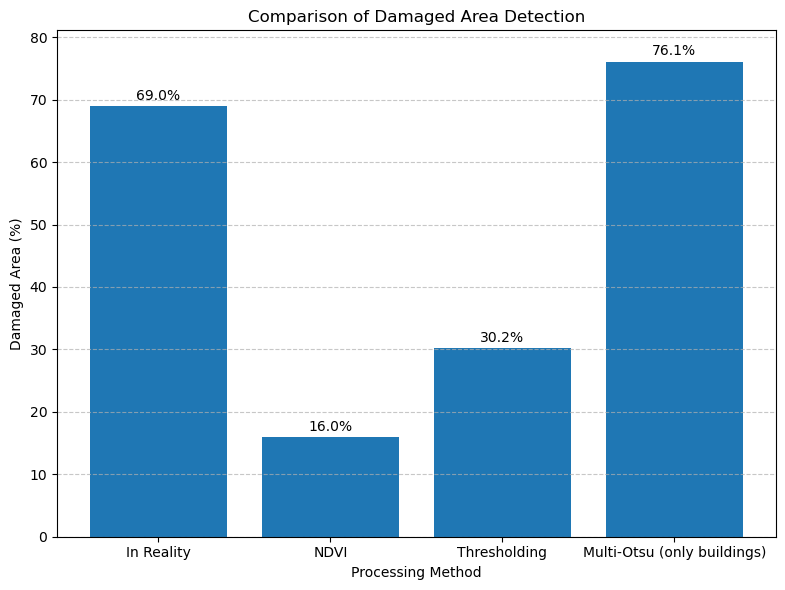

In [19]:
import matplotlib.pyplot as plt

methods = ['In Reality', 'NDVI', 'Thresholding', 'Multi-Otsu (only buildings)']
damaged_area_percentage = [69, 15.96, 30.23, 76.10]

plt.figure(figsize=(8, 6))
bars = plt.bar(methods, damaged_area_percentage)
plt.xlabel('Processing Method')
plt.ylabel('Damaged Area (%)')
plt.title('Comparison of Damaged Area Detection')
plt.ylim(0, max(damaged_area_percentage) + 5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()
